# Full Correlation Matrix Analysis

The connectivity analyses we performed previously examined the coupling of different regions of the brain. This coupling can capture information that activity-based univariate or multivariate techniques do not detect. For instance, imagine that voxel A and B are coupled during one task condition and voxel A and C are coupled during another task condition. In such a case, voxel A may always be active (and thus task differences are likely to be invisible to activity-based approaches), but its connectivity with other voxels will reveal task information.

However, this creates a problem: to find these diagnostic voxels in an unbiased, data-driven fashion it is necessary to correlate every voxel in the brain with every other voxel. Simplifying assumptions can be made to reduce the complexity of this analysis. For instance, it is possible to downsample the voxels (e.g., with parcellation) in order to reduce the total number of correlations that are made. 

Fortunately, advances in machine learning, parallel computing and efficient coding have made it possible to calculate and analyze billions of correlations rapidly. These tools are part of the BrainIAK toolbox and are used for Full Correlation Matrix Analysis (FCMA). This method is outlined in detail in Wang et al. (2015): http://ntblab.yale.edu/wp-content/uploads/2015/06/Wang_JNM_2015.pdf. In what follows we will learn how to run FCMA and actually perform it on real data on a reasonable timescale.

The logic of FCMA is as follows: take every voxel in the brain and correlate it with every other voxel in the brain for each trial and participant. Then, take each big correlation matrix and turn it into a vector so that every pairwise relationship is represented as a dimension in that vector. The vectors for each trial/condition can then be stacked so that we get an example by feature matrix. We can then feed that matrix into a classifier and determine whether the pattern of information across voxel pairs discriminates between conditions.  

For this script we will use the face/scene dataset from Wang et al. (2015).

## Goal of this script
1. Run FCMA feature selection
2. Run FCMA classification
3. Learn some plotting tools

## Table of Contents
[1. The FCMA Workflow](#fcma_wf)  
>[1.1 Data File Preparation](#data_prep)  
>[1.2 Create an epoch file](#epoch)  
>[1.3 Normalize data](#prep_for_fcma)  
>[1.4 Correlation and voxel selection](#vox_sel)  
>[1.5 Create voxel selection masks](#masks)  
>[1.6 Classification](#classify)  

[2. FCMA Batch Scripts](#fcma_batch)
>[2.1 Inner loop (subsample)](#fcma_inner)  
>[2.2 Outer loop (full sample)](#fcma_outer)  
>[2.3 Permutation testing](#fcma_perm)  

[3. Plotting the results](#plot) 
>[3.1 Plot the connectome](#connectome)  
>[3.2 Plotting circos](#circos)  

[4. MVPA and FCMA](#mvpa) 

### Exercises:  
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)    
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  
>[Exercise 9](#ex9)  
>[Exercise 10](#ex10)  
>[Exercise 11](#ex11)  
>[Novel contribution](#novel) 


## 1. The FCMA Workflow <a id="fcma_wf"></a>

The following sequence of steps are necessary for successfully running FCMA using BrainIAK. 

1. [**Data Preparation**](#data_prep) 

2. [**Create an epoch file**](#epoch)
    
3. [**Normalize data**](#prep_for_fcma) 

4. [**Correlation and voxel selection**](#vox_sel)

5. [**Create voxel selection masks**](#masks)

6. [**Classification**](#classify)

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys
import os

from nilearn import plotting
from nilearn.image import coord_transform

import brainiak.utils.fmrisim as sim
from brainiak.fcma.voxelselector import VoxelSelector
from brainiak.fcma.mvpa_voxelselector import MVPAVoxelSelector
from brainiak.fcma.preprocessing import prepare_fcma_data, prepare_mvpa_data
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.util import compute_correlation
from brainiak import io

### 1.1 Data Preparation <a id="data_prep"></a>

FCMA has tools to efficiently read in brain data but to do this, directories must be set up appropriately. Specifically, FCMA takes as an input a directory with the fMRI data you want to analyze. You can specify the suffix of the files you want to read in. Usually the suffix will just be '.nii.gz' but if you want to specify loading in only data from a certain condition then you might want a different kind of suffix. All data within the directory with the matching suffix will be loaded in and analyzed. 

Previous data we have analyzed were shared internally on Milgram. However, there is an increasing trend toward public data sharing and transparency, which may come into play for your final project... As an initial taste, we will use a public dataset for today's exercise.

In [2]:
# To begin, let's download the data
!./download_data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  251M  100  251M    0     0  38.2M      0  0:00:06  0:00:06 --:--:-- 43.9M


In [3]:
# Set paths
data_dir = './face_scene/'
suffix = '.nii.gz'
mask_file =  data_dir + 'mask.nii.gz'
epoch_file = data_dir + 'fs_epoch_labels.npy'

# Print the directory to see its contents
!ls $data_dir

# Create an image object that can be used by FCMA to load in data efficiently.
images = io.load_images_from_dir(data_dir, suffix)

# Use a path to a mask file to create a binary mask for FCMA
mask = io.load_boolean_mask(mask_file)

0202101_conatt_localizer_std_bet.nii.gz
0209101_conatt_localizer_std_bet.nii.gz
0209102_conatt_localizer_std_bet.nii.gz
0216101_conatt_localizer_std_bet.nii.gz
0216102_conatt_localizer_std_bet.nii.gz
0223101_conatt_localizer_std_bet.nii.gz
0225101_conatt_localizer_std_bet.nii.gz
0302101_conatt_localizer_std_bet.nii.gz
0309101_conatt_localizer_std_bet.nii.gz
0316101_conatt_localizer_std_bet.nii.gz
0413101_conatt_localizer_std_bet.nii.gz
0504101_conatt_localizer_std_bet.nii.gz
0506101_conatt_localizer_std_bet.nii.gz
0511101_conatt_localizer_std_bet.nii.gz
0511102_conatt_localizer_std_bet.nii.gz
0512101_conatt_localizer_std_bet.nii.gz
0728101_conatt_localizer_std_bet.nii.gz
0729101_conatt_localizer_std_bet.nii.gz
fs_epoch_labels_3sub.npy
fs_epoch_labels.npy
mask.nii.gz
prefrontal_top_mask.nii.gz
readme.txt
visual_top_mask.nii.gz


### 1.2 Create an epoch file <a id="epoch"></a>

What is an epoch? For the purposes of the FCMA package, an epoch is a time-interval that you want to carve up for analysis. FCMA needs to know which timepoints in the data correspond to which events. In the connectivity notebook our epochs were the entire run of data but in the code here this is just each block of faces or scenes. The stimuli were shown only for 12 TRs (18s) followed by 6 TRs (12s) of rest.

The epoch file has a very specific structure that makes it readible by BrainIAK. The epoch file is a list in which each entry is a 3d matrix of booleans. Each entry in this list corresponds to a participant/run (since there was one run per participant). The dimensions of the 3D matrix are condition (e.g., face vs. scene) by epoch (e.g., trial 1, 2, etc.) by TR.

**Exercise 1:**<a id="ex1"></a> Use plt.imshow to display the epoch by TR sequence for the face and scene conditions in the first participant, separately. Make sure the figure is big enough to read.

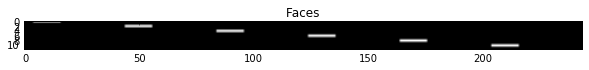

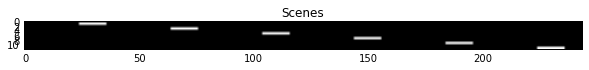

In [4]:
# Insert code here
epochs = np.load(epoch_file)
first_participant = epochs[0]

plt.set_cmap('gray')
plt.figure(figsize=(10,10))
plt.imshow(first_participant[0,:,:])
plt.title('Faces')

plt.figure(figsize=(10,10))
plt.imshow(first_participant[1,:,:])
plt.title('Scenes')

**Exercise 2:**<a id="ex2"></a> Create an epoch file that includes only the first 3 participants and name it: './face_scene/fs_epoch_labels_3sub.npy'

In [5]:
# Insert code here
first_three = epochs[:3]
np.save('./face_scene/fs_epoch_labels_3sub.npy', first_three)

Load in the new epoch file with the *io.load_labels* tool. We can also pull out some useful information from the epoch file such as how many epochs there are per person.

In [6]:
new_epoch_file = data_dir + 'fs_epoch_labels_3sub.npy'
epoch_list = io.load_labels(new_epoch_file)

# Parse the epoch data for useful dimensions
epochs_per_subj = epoch_list[0].shape[1]
num_subjs = len(epoch_list)

print('Number of participants:', num_subjs)
print('Number of epochs per participant:', epochs_per_subj)

Number of participants: 3
Number of epochs per participant: 12


### 1.3 Normalize data<a id="prep_for_fcma"></a>

The FCMA function takes in the brain images, mask and epoch file via the *prepare_fcma_data* function to format and normalize the data for analysis. This helps in speeding up the correlation computation and is a necessary step to use BrainIAKs optimized routines.

In [7]:
# Normalize and format the data. 
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)

In [8]:
print(len(raw_data))
print(len(labels))

print(raw_data[0].shape)
print(labels)

36
36
(12, 34470)
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


**Exercise 3:**<a id="ex3"></a> What does each list element of raw_data and labels represent? What does the dimensionality of the array in each raw_data list element represent?

**A:** Each list element of raw_data and labels represents one epoch. There are 3 subjects and 12 epochs/subject, hence 36 epochs total (the length of the arrays).

Each element in the labels array is a 0 or a 1, indicating whether faces or scenes were presented during that epoch.

Each element in the raw_data array is a 12-by-34,470 array. The 12 corresponds to the twelve TRs per epoch. The 34,470 corresponds to the number of voxels. Thus, each element is a voxel by TR matrix, specifying the total activity of the brain in a single epoch.

Note that this function has a nice feature: if your epoch_list has fewer entries than the number of images (e.g., you only made the epoch file for 3 participants, as we did here) then it will only take the first N images in the directory. In other words, if the epoch_list is subsampled then your images will also be subsampled. However, make sure you have the order right: It will only take the first N participants so make sure your epoch file corresponds to those same participants.

We are initially going to work with the first three participants to illustrate feature selection. This could take 20-30 mins on 2 cores. We will then use the results of feature selection for all participants (which we already calculated) to perform final classification. 

### 1.4 Correlation and voxel selection <a id="vox_sel"></a>

BrainIAK has optimized the computation of correlation matrices and the clasification of correlation patterns. The *VoxelSelector* method implements this massive computation (all voxels x all subjects x all epochs). *VoxelSelector* first computes the correlation of every voxel with every other voxel in the mask provided for each epoch and participant in the training set. It then trains a classifier for each voxel across the epochs of n-1 participants in the training set using the voxel's correlation values with all other voxels in the mask as features (as if it were a seed). Finally, it tests the classifier on the nth participant in the training set. This is repeated n times as a result of cross-validation and the accuracies are averaged across folds for each voxel. We can then rank voxels in terms of performance and use this ranking as a way to select which voxels have discriminative connectivity in the training set.

The computational workhorse behind FCMA is the code in *compute_correlation*. This is C code written with cython (a python binding for C code) that allows for extremely efficient computation of correlations.

**Exercise 4:**<a id="ex4"></a> What are the inputs to the compute_correlation function and what is the main trick this function pulls to speed up computation?  

**A:** From https://github.com/brainiak/brainiak/blob/master/brainiak/fcma/util.py:

The inputs to the function are two matrices.

According to the documentation, "Reducing the correlation computation to matrix multiplication and using BLAS GEMM API wrapped by Scipy can speedup the numpy built-in correlation computation (numpy.corrcoef) by one order of magnitude."

The following example extracts the data for one epoch, for one subject and computes the correlation using this procedure.

Analysis duration: 0.02814s


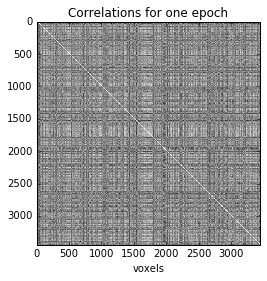

In [9]:
# Extract data for one subject, for one epoch (take only the every 10th voxel)
epoch_data=raw_data[0][:,::10]

# Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
mat = np.ascontiguousarray(epoch_data.T, dtype=np.float32)

# Voxels X TRs for one epoch
begin_time = time.time()
epoch_corr=compute_correlation(mat, mat)
end_time = time.time()
print("Analysis duration: %0.5fs" % (end_time - begin_time))

plt.figure()
plt.title('Correlations for one epoch');
plt.xlabel('voxels');
plt.imshow(epoch_corr);


The FCMA implementation in BrainIAK efficiently parallelizes and dessiminates the computation amongst the resources available. Below is a figure detailing the workflow of FCMA. The figure caption is quoted below:

![image](https://ars.els-cdn.com/content/image/1-s2.0-S0165027015001910-gr1.jpg)
>"Fig. 1. Workflow overview. FCMA uses a controller/worker architecture, in which each worker first loads the full data into memory. The full data consist of a matrix with V voxels in rows and T timepoints in columns; the timepoints can be subdivided into E epochs, each with TE timepoints (inset depicts two voxels and epochs). The controller process does the following: assigns a subset S of voxels to each of W workers; instructs the worker to compute the correlation between each of these voxels and the rest of the brain in each epoch; instructs the worker to analyze the correlation vectors for each voxel across epochs with MVPA and supplied condition labels; collects the analysis result (i.e., cross-validation accuracy) for each voxel and loads it into memory; and returns to the first step to assign another subset of voxels until there are none left. Finally, the controller writes the results to disk." Source:  Wang et al. (2015)

This computation cannot be run within a notebook because the controller and worker relationship needs at least 2 processors to run; whereas we are currently only using one for this notebook.

Instead we provide some [batch scripts](#fcma_batch) to execute the whole sequence of the FCMA workflow. However, the code isn't scary and actually does something quite similar to what we have done before with scikit-learn for classification: we create a classification object with the inputs we desire, specify the classification kernel and then run it.

>vs= VoxelSelector(labels, epochs_per_subj, num_subjs, raw_data)  
>clf = SVC(kernel='precomputed', shrinking=False, C=1)  
>results = vs.run(clf) 

In the exercise from week 5, we discussed different ways to perform cross-validation. One option is to leave out some unit or units of your data such as a run or a participant while you fit parameters or select voxels. In FCMA, it is typical to perform nested cross-validation in which we leave out a participant for final testing on an outer loop (e.g., participant 18) and perform our voxel selection with cross-validation on an inner loop with a participant left out to quantify feature selection performance (e.g., participant 17) and the rest used to conduct feature selection (e.g., participants 1-16). Thus, for each of 18 outer-loop folds, there are 17 inner-loop folds. To use this approach we simply ignore one subject's data before executing VoxelSelector (which does the inner loop itself). We can then use that data for final classifier testing. Then, on new iterations of the outer loop we can rotate which participants are to be ignored.

**Exercise 5:**<a id="ex5"></a> Leaving one participant out is arbitrary: we could leave out some blocks from all participants, multiple participants or any combination of these choices (as long as the training and testing data are independent). In the space below, write code using the *raw_data* and *labels* variables created by *prepare_fcma_data* to input into VoxelSelector with N-2 participants (i.e., 2 participants held out for final classifier testing). Print out the new shape of *raw_data* and *labels* to confirm your answer.

In [10]:
# Insert code

left_out_subj = 0  # Which participants (as an integer) are you leaving out for this cv?
start_idx = int(int(left_out_subj) * epochs_per_subj)
end_idx = int(start_idx + epochs_per_subj * 2)

# Take out the idxs corresponding to all participants but this one
subsampled_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
labels_subsampled = [labels[i] for i in subsampled_idx]
raw_data_subsampled = [raw_data[i] for i in subsampled_idx]

print(len(labels_subsampled))
print(len(raw_data_subsampled))

12
12


### 1.5 Create voxel selection masks <a id="masks"></a>

When we have each voxel labeled in terms of its average accuracy across inner loop folds we can then choose how many voxels we wish to include in building our classifier model to test the left-out outer-loop participant. The bash script we use here calls FSL commands to choose a subset of voxels (top N) and create a mask for each training set/outer-loop fold.  

In [11]:
!cat make_top_voxel_mask.sh

#!/bin/bash
#
# Takes in a results directory from fcma analysis and a certain number of voxels to threshold for a mask as input

module load Apps/FSL/5.0.9/

# Take inputs
input_dir=$1  # What is the path to thedata?
voxel_number=$2  # What voxel threshold would you like to set
output_dir=$3  # Where do you want to put the data

# Iterate through each volume in the fcma directory
for file in ${input_dir}/*_seq.nii.gz
do	
	# Preprocess the file name
	fbase=$(basename "$file")
	pref="${fbase%%.*}"
	
	# Create the voxel mask
	fslmaths $file -uthr $voxel_number -bin ${output_dir}/${pref}_top${voxel_number}.nii.gz

done

# Concatenate all of the masks from each volume
fslmerge -t ${output_dir}/all_top${voxel_number} ${output_dir}/fc_no*top${voxel_number}.nii.gz

# Create a probability map of each voxel being included across participants
fslmaths ${output_dir}/all_top${voxel_number} -Tmean ${output_dir}/prop_top${voxel_number} -odt float


**Exercise 6:**<a id="ex6"></a> What is the difference between the "prop_top\${voxel_number}.nii.gz", "all_top\${voxel_number}.nii.gz" and "fc_no\${subj}_result_seq_top\$num.nii.gz" masks (where \${voxel_number} is the number of voxels included and $subj is the outer-loop subject number)?

**A:** 

all_top\${voxel_number}.nii.gz is a stacked set of masks from each subject, with the exception of the left-out subject. If a voxel is within the top \${voxel_number} most accurate voxels for a given subject, it is labeled 1, else it is 0.

prop_top\${voxel_number}.nii.gz is a probability map of each voxel being included across participants, with the exception of the left-out subject. In other words, it is the fraction of times each voxel is included in the top \${voxel_number} most accurate voxels for a given subject, calculated by averaging over the all_top array.

fc_no\${subj}_result_seq_top\$num.nii.gz is the mask for the left-out subject. This is calculated using the VoxelSelector tool in brainiak.fcma. This is the mask that we will use for the classficiation step, where we test on that participant.

### 1.6 Classification <a id="classify"></a>

On this subset of top N voxels we perform classification of the correlation patterns by first training on the subjects we used for voxel selection (**all** participants in the training set) and then testing on the held-out outer-loop participant that wasn't used for any previous analyses.

BrainIAK has a special method, called *Classifier*, that will compute correlations on the selected voxels and perform classification in a computationally efficient manner. We have created the script *fcma_classify.py* as a wrapper. This script is similar to the voxel selection script: data are loaded into memory on each processor, then normalized and prepared for input to FCMA, a *Classifier* object is made from the data and then fit. Like voxel selection, this can be called in a similar way to the classification tools from scikit-learn.

Critically, the mask input to the *fcma_classify.py* is not the whole brain mask but is instead the top N voxels that are deemed appropriate for this outer-loop fold.

As before the code is relatively tractable and familiar; however, again we cannot run this in the notebook because of the need for parallelism. Once our data and labels are arranged into training and test sets we create objects that are ready to be read by FCMA. We then create our SVM kernel and Classifier object. This Classifier object is then fit to the training data before being tested on the never-before-seen test data.

>training_obj = list(zip(training_data, training_data))  
>testing_obj = list(zip(testing_data, testing_data))  

>svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)  
>clf = Classifier(svm_clf, epochs_per_subj=epochs_per_subj)  

>clf.fit(training_obj, training_labels)  
>predict = clf.predict(testing_obj)  

If you look at the *fcma_classify.py* script you will notice that there is an alternative way to organize the data and feed it into the classifier function. If you concatenate the training and testing data then zip it into a single object, this is much more memory efficient. The FCMA code then takes account of how many training samples there are and **NEVER** looks at the test data when fitting the model. This procedure is thus better, although a little harder to understand. 

Users of FCMA have found it useful to distinguish between intrinsic and extrinsic classification. 

> Intrinsic classification, demonstrated above, is when the correlations of only the voxels in the top_n_mask are used for classification. In other words this method only cares about correlations among those voxels that were selected because they contain information.  

> Extrinsic classification is when the correlations used for final classification are between voxels within the top_n_mask and voxels outside of this mask. In other words this method examines information captured by these nodes with the rest of the brain.

The scripts we provide allow you to specify whether you wish to perform intrinsic or extrinsic FCMA

## 2. FCMA Batch Scripts <a id="fcma_batch"></a>

We have covered the main functions needed to run a FCMA analysis. Some of these methods require multiple cores for fast execution and thus cannot be executed from cells in a Jupyter notebook. The scripts are described below:



*run_fcma_voxel_selection_cv.sh:* This runs *fcma_voxel_selection_cv.py* which loads in the data, formats it, performs normalization, and VoxelSelection. The bash script takes in 6 inputs:
1. data_dir=What is the directory containing data? 
        e.g. "./face_scene/"
2. suffix=What is the extension of the data you're loading 
        e.g. ".nii.gz"
3. mask_file=What is the path to the whole brain mask 
        e.g. "./face_scene/mask.nii.gz"
4. epoch_file=What is the path to the epoch file 
        e.g. "./face_scene/fs_epoch_labels_3sub.npy"
5. left_out_subj=Which participant (as an integer) are you leaving out for this cv? 
        e.g. "0"
6. output_dir=Where do you want to save the data
        e.g. "./voxel_selection_subsample"



*make_top_voxel_mask.sh:* Creates binary masks of the top N voxels for each file generated by voxel selection in a given folder. This creates a mask for each participants and then aggregate masks. This takes the following inputs:
1. input_dir=What is the path to the data?
        e.g. "./voxel_selection_subsample/"
2. voxel_number=What voxel threshold would you like to set
        e.g. "1000"
3. output_dir=Where do you want to put the data
        e.g. "./top_n_masks_subsample/"




*run_fcma_classify.sh:* This runs *fcma_classify.py* which performs classification of the voxels selected by VoxelSelection, using the *Classifier* method. This takes the following inputs:
1. data_dir=What is the directory containing data? 
        e.g. "./face_scene/"
2. suffix=What is the extension of the data you're loading 
        e.g. ".nii.gz"
3. top_n_mask_file=What is the path to the top N mask file (**THIS IS NOT THE WHOLE BRAIN MASK**) 
        e.g. "./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz"
4. epoch_file=What is the path to the epoch file 
        e.g. "./face_scene/fs_epoch_labels.npy"
5. left_out_subj=Which participant (as an integer) are you using for testing? 
        e.g. "0"
6. second_mask=Do you want to use a second mask to compare the data with? Necessary for extrinsic analyses. Otherwise set to None.
        e.g. "None"

### 2.1 Inner loop (subsample)<a id="fcma_inner"></a>

Although the FCMA tools have greatly sped up the computation time required for these analyses, it still takes a long time to compute a trillion correlations, as is needed for voxel selection with this dataset. Hence we are only going to run these voxel selection on three participants.

**Exercise 7:**<a id="ex7"></a> Perform the following steps for first 3 participants:  
1. Check that you have created the epoch file with the first 3 participants and it is called "./face_scene/fs_epoch_labels_3sub.npy"
2. Run the voxel selection, leaving one of the participants out each time. You can use the example inputs specified above for the first participant. This can take a while with only 2 cores.
3. Create a mask of the top **100** voxels using the *make_top_voxel_mask.sh* script. You can use the example inputs specified above for the first participant.

**Exercise 8:**<a id="ex8"></a> Plot the mask of the top **100** voxels for each participant using nilearn.plotting

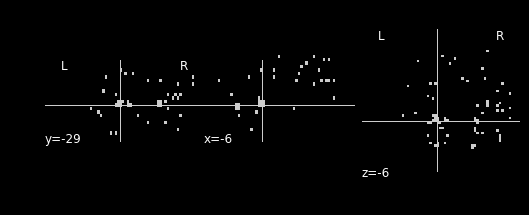

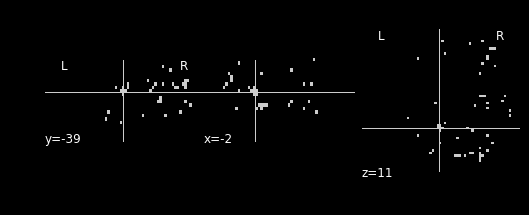

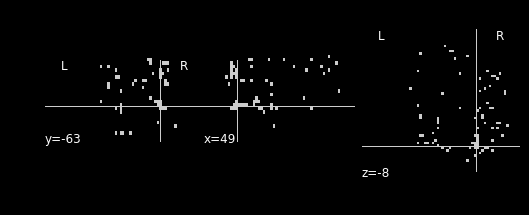

In [12]:
for i in range(num_subjs):
    img_name = './top_n_masks_subsample/fc_no' + str(i) + '_result_seq_top1000.nii.gz'
    plotting.plot_epi(img_name)

### 2.2 Outer loop (all)<a id="fcma_outer"></a>

The above exercise was to familiarize you with how the voxel selection step works. This step is slow because we are calculating the full correlation matrix and a separate cross-validation is performed for every voxel's connectivity. However, the outer loop is relatively fast for intrinsic analyses because we are only training and testing on a subset of voxels. Hence we will use voxel selection data we prepared earlier to run the final classification for each participant. Note that the selected features will be slightly different for each outer-loop participant because the training sets differ.

In [13]:
! ls /gpfs/milgram/data/cmhn-s18/datasets/face_scene/voxel_selection_all/

fc_no0_result_list.txt	     fc_no18_result_seq.nii.gz
fc_no0_result_score.nii.gz   fc_no1_result_list.txt
fc_no0_result_seq.nii.gz     fc_no1_result_score.nii.gz
fc_no10_result_list.txt      fc_no1_result_seq.nii.gz
fc_no10_result_score.nii.gz  fc_no2_result_list.txt
fc_no10_result_seq.nii.gz    fc_no2_result_score.nii.gz
fc_no11_result_list.txt      fc_no2_result_seq.nii.gz
fc_no11_result_score.nii.gz  fc_no3_result_list.txt
fc_no11_result_seq.nii.gz    fc_no3_result_score.nii.gz
fc_no12_result_list.txt      fc_no3_result_seq.nii.gz
fc_no12_result_score.nii.gz  fc_no4_result_list.txt
fc_no12_result_seq.nii.gz    fc_no4_result_score.nii.gz
fc_no13_result_list.txt      fc_no4_result_seq.nii.gz
fc_no13_result_score.nii.gz  fc_no5_result_list.txt
fc_no13_result_seq.nii.gz    fc_no5_result_score.nii.gz
fc_no14_result_list.txt      fc_no5_result_seq.nii.gz
fc_no14_result_score.nii.gz  fc_no6_result_list.txt
fc_no14_result_seq.nii.gz    fc_no6_result_score.nii.gz
fc_no15_result_list.txt     

Note, these masks will be different from the ones that you created because they are trained on substantially more data. 

**Self-study:** Visualize the masks that were previously created. You can use the code: 
>module load Apps/FSL/5.0.9  
>fslview /gpfs/milgram/data/cmhn-s18/datasets/face_scene/voxel_selection_all/fc_no0_result_score.nii.gz

**Exercise 9:**<a id="ex9"></a> Create a mask of the top **1000** voxels using the *make_top_voxel_mask.sh* script. Use the 'voxel_selection_all' folder (full path above) as an input and the './top_n_masks_all' folder as the output destination.

**Exercise 10:**<a id="ex10"></a> Perform intrinsic classification on all participants using the *run_fcma_classify.sh* script. You can use all of the example inputs specified above. Once this has finished, the cell below will print out the 18 outer-loop classification accuracies. Use these to calculate the overall mean performance.

In [14]:
!cat classify_result.txt

./top_n_masks_all/fc_no12_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no15_result_seq_top1000.nii.gz, intrinsic: 0.583333333333
./top_n_masks_all/fc_no13_result_seq_top1000.nii.gz, intrinsic: 0.916666666667
./top_n_masks_all/fc_no14_result_seq_top1000.nii.gz, intrinsic: 0.833333333333
./top_n_masks_all/fc_no16_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no5_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no6_result_seq_top1000.nii.gz, intrinsic: 0.666666666667
./top_n_masks_all/fc_no4_result_seq_top1000.nii.gz, intrinsic: 0.833333333333
./top_n_masks_all/fc_no3_result_seq_top1000.nii.gz, intrinsic: 0.916666666667
./top_n_masks_all/fc_no2_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no1_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.916666666667
./top_n_masks_all/fc_no10_result_seq_top1000.nii.gz, intrinsic: 1.0
./top_n_masks_all/fc_no7_result_seq_top1000.ni

In [15]:
print('Average Accuracy:')
accs = np.array([1.0, 0.583333333333, 0.91666666667, 0.833333333333, 1.0, 1.0,
        0.666666666667, 0.833333333333, 0.916666666667, 1.0, 1.0, 
        0.916666666667, 1.0, 1.0, 0.916666666667, 1.0, 0.833333333333])
np.mean(accs)

Average Accuracy:


0.90686274509823528

### 2.3 Permutation testing <a id="fcma_perm"></a>

FCMA also has tools to allow for easy permutation of data. This way you can determine, by running this analysis many times, the distribution of classification accuracy for a null effect and how the real effect stacks up. The code below shows how to do this permutation. 

In [16]:
# Note that you must run this every time you wish to call prepare_fcma_data
images = io.load_images_from_dir(data_dir, suffix)

# Setting the random argument produces random voxel selection results
# for non-parametric statistical analysis.
# There are three random options:
# RandomType.NORANDOM is the default
# RandomType.REPRODUCIBLE permutes the voxels in the same way every run
# RandomType.UNREPRODUCIBLE permutes the voxels differently across runs
permuted_raw_data, _, permuted_labels = prepare_fcma_data(images, epoch_list, mask, random=RandomType.REPRODUCIBLE)

**Exercise 11:**<a id="ex11"></a> Perform a permutation analysis by doing the following steps:
1. Create a new version of the *fcma_classify.py* script that permutes the data (like the code above) and name it *fcma_classify_permuted.py*.
2. Have this script output the accuracy to a text file called *classify_result_permuted.txt*.
3. Create a new version of the *run_fcma_classify.sh* script that executes *fcma_classify.py* and name it *run_fcma_classify_permuted.sh*. 
4. On the first outer-loop participant, run this analysis 10 times to get a distribution of null classification accuracies. Print the results below and calculate the mean.

In [17]:
!cat classify_result_permuted.txt

./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5
./top_n_masks_all/fc_no0_result_seq_top1000.nii.gz, intrinsic: 0.5


## 3. Plotting the results <a id="plot"></a>

As always, it is useful to visualize our results to get an idea of where in the brain the contains information. However, in the case of FCMA, remember the information isn't localized to a voxel but instead is captured in the relationship between voxel. Hence we typically want to plot a connectome rather than a heatmap. Fortunately, nilearn provides great tools for plotting a connectome!

### 3.1 Plot the connectome <a id="connectome"></a>

Below we are going to load in a mask that we have created and then compute correlations of every voxel in the mask with every other voxel in the mask (intrinsic). We are then going to create a connectome based on the strongest correlations.

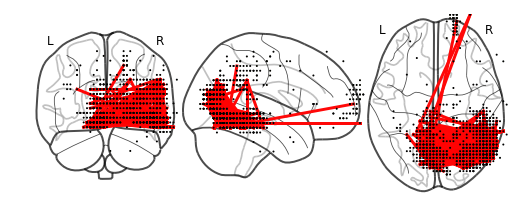

In [18]:
# Load in the data
epoch_data = raw_data[0] # Just load a single subject and a single epoch
mask_top_n_file = './top_n_masks_all/fc_no0_result_seq_top1000.nii.gz'
mask_top_n_nii = nib.load(mask_top_n_file) # Load the mask that leaves that participant out
mask_top_n = mask_top_n_nii.get_data()

# Convert the top n mask into a vector with the same number of elements as the whole brain
mask_vec = mask.reshape(np.prod(mask.shape))
mask_top_vec = mask_top_n.reshape(np.prod(mask_top_n.shape))[mask_vec]

# Mask the epoch data
epoch_data_masked = epoch_data[:, mask_top_vec==1]

# Make the data c continguous 
epoch_data_masked = np.ascontiguousarray(epoch_data_masked.T, dtype=np.float32)

# Create the internal correlation
epoch_corr = compute_correlation(epoch_data_masked, epoch_data_masked)

# Pull out the coordinates of the mask (in numpy space)
coord_x, coord_y, coord_z = np.where(mask_top_n == 1)

# Convert from the input space into MNI coordinates
coords = coord_transform(coord_x, coord_y, coord_z, mask_top_n_nii.affine)

# Save for later
np.save("epoch_corr", epoch_corr)
np.save("epoch_corr_coords", coords)

# Plot the connectome (only connections in above the specified percentile will be plotted)
plotting.plot_connectome(epoch_corr, 
                         np.transpose(coords), 
                         edge_threshold="99.9%", 
                         node_size=1);

### 3.2 Plotting circos <a id="circos"></a>

**Self-study:** If someone tells you that science isn't art then that person has never seen a circos plot:


![image](http://mkweb.bcgsc.ca/tableviewer/userimg/circos-table-fdnrtsf.jpg)

These are new tools for visualizing complex data. These take in a correlation matrix and treat each row/column of the matrix as a point around the circle. They then draw a connection to points that exceed a certain threshold. These plots can then be used to display high-dimensional ROI data like you saw above.

This [website](http://mkweb.bcgsc.ca/tableviewer/visualize/) allows you to upload a table of data and make a circos plot. If you would like, you can use the script below to save a correlation matrix as a table that can be read into the website. You could then upload that into your git repo and render it in this notebook or you could download the file directly from the repo. Mileage may vary with the website but when it works it is great. Note that you cannot have a matrix that is bigger than 75 * 75 so figure out how to select your data first.

In [19]:
# Print circos compatibile information
fid = open('circos_table.txt', 'w')
for voxel_row in range(epoch_corr.shape[0]):
    
    # Do something different for the first row
    if voxel_row == 0:
        line = 'Labels\t'

        for voxel_col in range(epoch_corr.shape[1] - 1):
            line += "vox_" + str(voxel_col) + '\t'
    else:
        
        # Pull out the label and the content of the first line
        line = "vox_" + str(voxel_row -1) + '\t'
        for voxel_col in range(epoch_corr.shape[1]):
            weight = int(abs(epoch_corr[voxel_row - 1, voxel_col]*100))  # Must be positive integers
            line += str(weight) + '\t'
    
    # Write the line you have prepared
    fid.write(line + '\n')

# Close the text file that was created
fid.close()

In [ ]:
!less circos_table.txt

Labels  vox_0   vox_1   vox_2   vox_3   vox_4   vox_5   vox_6   vox_7   vox_8    vox_9   vox_10  vox_11  vox_12  vox_13  vox_14  vox_15  vox_16  vox_17  vox_18   vox_19  vox_20  vox_21  vox_22  vox_23  vox_24  vox_25  vox_26  vox_27  vox_28   vox_29  vox_30  vox_31  vox_32  vox_33  vox_34  vox_35  vox_36  vox_37  vox_38   vox_39  vox_40  vox_41  vox_42  vox_43  vox_44  vox_45  vox_46  vox_47  vox_48   vox_49  vox_50  vox_51  vox_52  vox_53  vox_54  vox_55  vox_56  vox_57  vox_58   vox_59  vox_60  vox_61  vox_62  vox_63  vox_64  vox_65  vox_66  vox_67  vox_68   vox_69  vox_70  vox_71  vox_72  vox_73  vox_74  vox_75  vox_76  vox_77  vox_78   vox_79  vox_80  vox_81  vox_82  vox_83  vox_84  vox_85  vox_86  vox_87  vox_88   vox_89  vox_90  vox_91  vox_92  vox_93  vox_94  vox_95  vox_96  vox_97  vox_98   vox_99  vox_100 vox_101 vox_102 vox_103 vox_104 vox_105 vox_106 vox_107 vox_108  vox_109 vox_110 vox_111 vox_112 vox_113 vox_114 vox_115 vox_116 vox_117 vox_118  vox_119 vox_120 

Circos packages are becoming more available now in the python community. For those really interested you should look at the [nxviz](https://github.com/ericmjl/nxviz) github repository. On milgram a module for this has been created to let you make circos plots. However, to be able to use it you need to load different modules (this package has different dependencies than BrainIAK). To do this, run "sbatch ./run_jupyter_circos.sh" to set up an appropriate environment and open this notebook. Do not attempt to re run everything in this notebook, the circos environment does not have brainiak. Instead just run the contents of the cell below and it will work (assuming every other exercise in this notebook is done).

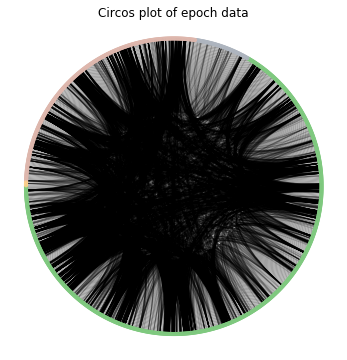

In [1]:
# Import the necessary libraries (and not extra)
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from nxviz.plots import CircosPlot
%matplotlib inline

# What is the (absolute) correlation threshold
threshold = 0.9

# Load in the data
epoch_corr = np.load("epoch_corr.npy")
epoch_coords = np.load("epoch_corr_coords.npy")

# Preset the graph
G = nx.Graph()

# Create the edge list
nodelist = []
edgelist = []
for row_counter in range(epoch_corr.shape[0]):
    nodelist.append(str(row_counter))  # Set up the node names
    
    for col_counter in range(epoch_corr.shape[1]):
        
        # Determine whether to include the edge based on whether it exceeds the threshold
        if abs(epoch_corr[row_counter, col_counter]) > threshold:
            # Add a tuple specifying the voxel pairs being compared and the weight of the edge
            edgelist.append((str(row_counter), str(col_counter), {'weight': epoch_corr[row_counter, col_counter]}))
        
# Create the nodes in the graph
G.add_nodes_from(nodelist)

# Add the edges
G.add_edges_from(edgelist)

# Set the colors and grouping (specify a key in a dictionary that can then be referenced)
for n, d in G.nodes(data=True):
    
    # Is the x coordinate negative (left)
    if epoch_coords[0][int(n)] < 0:
        if epoch_coords[1][int(n)] < 0:
            G.node[n]['grouping'] = 'posterior_left'
        else:
            G.node[n]['grouping'] = 'posterior_right'
    else:
        if epoch_coords[1][int(n)] < 0:
            G.node[n]['grouping'] = 'anterior_left'
        else:
            G.node[n]['grouping'] = 'anterior_right'

# plot the data
c = CircosPlot(graph=G, node_grouping='grouping', node_color='grouping')
c.draw()
plt.title('Circos plot of epoch data');

## 4. MVPA and FCMA<a id="mvpa"></a>

The FCMA workflow is intentionally set up in BrainIAK to be parallel to MVPA. Rather than looking at correlations, this simply uses patterns of activity across different trials to discriminate conditions. As before there are scripts available for voxel selection and final classification. Here voxel selection is based on a searclight analysis in n-1 participants.

**Self-study:** With a few line changes it is possible to run MVPA with the code above. Investigate what you need to change to make this happen, and feel free to run this analysis (at least on a subset of participants) for your novel contribution.

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

In [34]:
#see how many of the most accurate voxels (calculated above) match up across the first three subjects

subj0 = io.load_boolean_mask('./top_n_masks_subsample/fc_no0_result_seq_top1000.nii.gz')
subj1 = io.load_boolean_mask('./top_n_masks_subsample/fc_no1_result_seq_top1000.nii.gz')
subj2 = io.load_boolean_mask('./top_n_masks_subsample/fc_no2_result_seq_top1000.nii.gz')

print('fraction of 1000 most accurate voxels shared between subjs 0 and 1')
print(np.sum(subj0 * subj1) / 1000.0)

print('\nfraction of 1000 most accurate voxels shared between subjs 1 and 2')
print(np.sum(subj1 * subj2) / 1000.0)

print('\nfraction of 1000 most accurate voxels shared between subjs 0 and 2')
print(np.sum(subj0 * subj2) / 1000.0)

fraction of 1000 most accurate voxels shared between subjs 0 and 1
0.054

fraction of 1000 most accurate voxels shared between subjs 1 and 2
0.063

fraction of 1000 most accurate voxels shared between subjs 0 and 2
0.049
